# Table of Contents
1 - [Problem Statement](#ps)  
2 - [Overview of Dataset](#dataset)  
3 - [Loading the Data](#load)   
4 - [Exploratory Data Analysis](#eda)   
&emsp;  4.1 - [Data Cleaning: Deduplication](#deduplication)  
5 - [Text Preprocessing Using NLTK](#textprep)  
6 - [Text Featurization and t-SNE Visualization](#tsne)    
&emsp;  6.1 - [Bag Of Words(unigram)](#bowuni)    
&emsp;  6.2 - [Bag Of Words(bigram)](#bowbi)  
&emsp;  6.3 - [TF-IDF(unigram)](#tfidfuni)  
&emsp;  6.4 - [TF-IDF(bigram)](#tfidfbi)  
&emsp;  6.5 - [Word2Vec model using all the Reviews](#w2v)  
&emsp;  6.6 - [Average Word2Vec](#avgw2v)  
&emsp;  6.7 - [TF-IDF Weighted Word2Vec](#tfidfw2v)  
7 - [Conclusion](#conclusion)

## [1] Problem Statement : <a name="ps"></a>

t-SNE Visualization of Amazon reviews(either positive or negative) with polarity based color-coding using : 

&emsp; 1)Bag Of Words  
&emsp; 2)TF-IDF  
&emsp; 3)Average Word2Vec  
&emsp; 4)TF-IDF Weighted Word2Vec  

## [2] Overview of Dataset : <a name="dataset"></a>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.  

Number of reviews: 568,454  
Number of users: 256,059  
Number of products: 74,258  
Timespan: Oct 1999 - Oct 2012  
Number of Attributes/Columns in data: 10  

Attribute Information:

&emsp;1.Id  
&emsp;2.ProductId - unique identifier for the product  
&emsp;3.UserId - unqiue identifier for the user  
&emsp;4.ProfileName  
&emsp;5.HelpfulnessNumerator - number of users who found the review helpful  
&emsp;6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not  
&emsp;7.Score - rating between 1 and 5  
&emsp;8.Time - timestamp for the review  
&emsp;9.Summary - brief summary of the review  
&emsp;10.Text - text of the review  

Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## [3] Loading the Data : <a name="load"></a>

In order to load the data, we have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [42]:
#Importing the necessary Packages
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import time
import sqlite3
import pandas as pd
pd.set_option('max_colwidth',25)
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import HTML

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [29]:
import pickle

#dumping an object to file object using dump method
def dumpfile(a,file_Name):
    fileObject = open(file_Name,"wb")
    pickle.dump(a,fileObject,protocol=2)
    fileObject.close()

#loading an object from file object using load method
def loadfile(file_Name):
    fileObject = open(file_Name,"rb")
    b = pickle.load(fileObject)
    return b


In [30]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 


#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [31]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [37]:
print("Number of datapoints: ",filtered_data.shape[0])
print("Number of attributes/features: ",filtered_data.shape[1])
HTML(filtered_data.head().to_html(index=False))

Number of datapoints:  525814
Number of attributes/features:  10


## [4] Exploratory Data Analysis :<a name="eda"></a>

### [4.1] Data Cleaning: Deduplication <a name="deduplication"></a>
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

<b>Deduplication 1:-</b> As can be seen below the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [38]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

In [18]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [19]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

<b>Deduplication 2:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [39]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

In [21]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(364171, 10)


<b>Deduplication 3:-</b> It was also seen that a same user has given different reviews for a same product at same time.I think it is normal for a user to give multiple reviews about a product,but that should be in diffrent time.<br>
So,all those rows with same user giving multiple reviews for a same product at same time are considered as duplicate and hence dropped.

In [40]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId= "A8891HVRDJAM6" 
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

In [23]:
final=final.drop_duplicates(subset={"ProductId","UserId","ProfileName","Time"}, keep='first', inplace=False)
print(final.shape)

(363633, 10)


<b>Deduplication 4:-</b> It was also seen that in few rows with Ids from 150493 to 150529 contain reviews regarding books,not fine foods.So I think these should be also removed from the dataset.
After looking at the productid column, it can be noticed that all the observations for fine foods start with B followed by numbers except for Ids from 150493 to 150529. 
I suppose the reviews for book ‘Chicken soup for the soul’ have gotten into the datset mistakenly as they contain the words “chicken soup.

In [41]:
display = final[final.ProductId == "0006641040"]
HTML(display.head().to_html(index=False))

In [96]:
final = final[final.ProductId != "0006641040"]

In [100]:
print("Percentage  of data still remaining : ",(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

#Before starting the next phase of preprocessing lets see the number of entries left
print("Number of reviews left after Data Cleaning and Deduplication :")
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

Percentage  of data still remaining :  69.14973735959865
Number of reviews left after Data Cleaning and Deduplication :
(363599, 10)


positive    306566
negative     57033
Name: Score, dtype: int64

<b>Observation:-</b>  
It is an imbalanced dataset as the number of positive reviews are way high in number than negative reviews.

## [5] Text Preprocessing Using NLTK : <a name="textprep"></a>

In the Preprocessing phase we do the following in the order below:-

1. Removal of HTML Tags
2. Removal of  any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Removal of  Stopwords
7. Finally Snowball Stemming the word <br>

After which we collect the words used to describe positive and negative reviews

In [66]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

10
I wanted a treat that was accepted and well liked for my rescue animals.<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains or silly vegetables which virtually all treats contain. Dogs, cats and ferrets are carnivores they are not cattle to eat grain or rabbits to eat vegetables, and WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods? It is dangerous and can cause the death of an animal with diabetes.<br />It is pretty easy to break into smaller pieces for cats and kittens with weak jaws and its wonderful to use as an aid to gain the trust of an abused dog as it will not cause stomach upset when given in common sense amounts.<br />I like that it goes a long way as it costs alot to heal and maintain and train abused and rescued dogs.<br />NO minus to this product other then the price,I can not afford to use it as much as I would like.


### [5.1] Removal of html Tags :

In [67]:
#function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

cleanhtml("<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains")

' This is the only treat that is healthy and loved by all 4 legged beings in my home! It does not contain sugar or grains'

### [5.2] Removal of Punctuations and unecessary characters :

In [68]:
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#|@|~|%|*]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

cleanpunc("WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods?")

'WHYYYY do companies add sugar beet pulp or corn syrup to carnivore foods'

### [5.3] StopWords :

In [69]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
  
stop = set(stopwords.words('english')) #set of stopwords
print(stop)
print("*********************************************************************")
print("No. of stop words: ",len(stop))

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'wouldn', 'had', 'during', 'before', 'up', 'nor', "she's", 'very', 'himself', 'aren', 'out', 're', 'against', 'some', 'to', 'under', 'so', 'than', 'where', 'whom', 'my', 'until', "you're", 'after', 'will', 'again', 'weren', 'when', "you'd", 'most', 'having', 'yours', 'with', "couldn't", 'm', 'who', 'you', 'does', 'once', 'did', "mightn't", 'own', 'which', 'was', 'itself', 'by', 'such', 'haven', 'further', 'there', 'o', 'am', "hasn't", 'yourself', 'why', 'here', 'hers', 'above', "you've", 'ours', 'herself', "needn't", 'should', 'the', 'over', 'needn', 'have', 'same', "doesn't", 'won', 'be', 'he', 'being', 'it', 'll', 'in', 'can', 'ma', 'themselves', 'below', "that'll", 'shan', 'ourselves', 'their', 'as', 'couldn', 'but', 'or', "weren't", 'her', '

In [70]:
exceptions = ["aren't","mightn","wasn","hadn","don't","against","hadn't","shan","weren't","didn","don","hasn't", \
              "hasn","shouldn","didn't","wouldn","wasn't","needn't","shouldn't","wouldn't","aren","isn't","doesn't", \
              "nor","not","needn","couldn't","mightn't","mustn","mustn't","ain","shan't","haven","won't","couldn","isn", \
              "weren","haven't","no","haven't"]
new_stop = []
for i in stop:
    if i not in exceptions:
        new_stop.append(i)


print("No. of stop words after removing exceptions: ",len(new_stop))

No. of stop words after removing exceptions:  140


### [5.4] Stemming :

In [71]:
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

print("Orginal word: beautiful" + "|" +  "Stem word: " + sno.stem('beautiful'))
print("Orginal word: beauty" + "|" +  "Stem word: " + sno.stem('beauty'))
print("Orginal word: loved" + "|" +  "Stem word: " + sno.stem('loved'))
print("Orginal word: loving" + "|" +  "Stem word: " + sno.stem('loving'))

Orginal word: beautiful|Stem word: beauti
Orginal word: beauty|Stem word: beauti
Orginal word: loved|Stem word: love
Orginal word: loving|Stem word: love


<b>Observation:-</b>  
We can see words like "beautiful" and "beauty" have their stem as "beauti","loved" and "loving" have their stem as "love".  
Hence it helps in reducing the dimensions by taking the root stem of words.

### [5.5] Implementing the preprocessing steps one by one on all the<br>reviews of dataset :

In [72]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [83]:
from nltk.probability import FreqDist
pdist = FreqDist(all_positive_words)
top_positive = pdist.most_common(20)
print("Top 20 Positive words ocuring frequenty in reviews:")
top_positive

Top 20 Positive words ocuring frequenty in reviews:


[(b'like', 139160),
 (b'tast', 128865),
 (b'good', 112601),
 (b'flavor', 109329),
 (b'love', 107172),
 (b'use', 103792),
 (b'great', 103670),
 (b'one', 96529),
 (b'product', 90912),
 (b'tri', 86683),
 (b'tea', 83699),
 (b'coffe', 78763),
 (b'make', 75004),
 (b'get', 71996),
 (b'food', 64539),
 (b'would', 55477),
 (b'time', 55184),
 (b'buy', 54137),
 (b'realli', 52657),
 (b'eat', 51868)]

In [82]:
ndist = FreqDist(all_negative_words)
top_negative = ndist.most_common(20)
print("Top 20 Negative words ocuring frequenty in reviews:")
top_negative

Top 20 Negative words ocuring frequenty in reviews:


[(b'tast', 34534),
 (b'like', 32271),
 (b'product', 28181),
 (b'one', 20544),
 (b'flavor', 19520),
 (b'would', 17947),
 (b'tri', 17718),
 (b'use', 15280),
 (b'good', 15024),
 (b'coffe', 14700),
 (b'get', 13775),
 (b'buy', 13742),
 (b'order', 12862),
 (b'food', 12720),
 (b'dont', 11865),
 (b'tea', 11646),
 (b'even', 11068),
 (b'box', 10833),
 (b'amazon', 10067),
 (b'make', 9826)]

### [5.6] Adding a new column of CleanedText which displays the data after<br>pre-processing of the review  :

In [ ]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [39]:
final[['Text','CleanedText']].head(10)

Text                    CleanedText
0  This product by Archer Far...  product archer farm best d...
1  Our dogs just love them.  ...  dog love saw pet store tag...
2  My dogs loves this chicken...  dog love chicken product c...
3  This book is easy to read ...  book easi read ingredi ava...
4  I have been feeding my gre...  feed greyhound treat year ...
5  This is one product that m...  one product welsh terrier ...
6  This is the ONLY dog treat...  dog treat lhasa apso eat m...
7  These liver treas are phen...  liver trea phenomen receiv...
8  This was the only treat my...  treat dog like obedi train...
9  No waste , even if she is ...  wast even day goe hunger s...

### [5.7] Using SQLite Table to load data after preprocessing <br> of reviews  :

In [ ]:
# store final result into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [37]:
# using the SQLite Table to read data.
conn = sqlite3.connect('final.sqlite') 

final = pd.read_sql_query(""" SELECT * FROM Reviews """,conn) 

In [7]:
#Listing out the number of positive and negative reviews
final = final.reset_index(drop=True)
final['Score'].value_counts()

positive    306566
negative     57033
Name: Score, dtype: int64

In [8]:
cleanedtext = final.drop("Score",1)
score = final["Score"]

### [5.7] Sampling 20k Reviews(10k positive and 10k negative) from the dataset:

In [9]:
def reviews_eq_split(X, y, n_per_class, random_state=0):
    sampled = X.groupby(y, sort=False).apply(
        lambda frame: frame.sample(n_per_class))
    indexes = sampled.index.get_level_values(1)

    text = X.loc[indexes]
    score = y.loc[indexes]

    return text,score

final_text,final_score = reviews_eq_split(cleanedtext,score,n_per_class = 10000, random_state=0 )
final_score.value_counts()

negative    10000
positive    10000
Name: Score, dtype: int64

## [6] Text Featurization and t-SNE Visualization : <a name="tsne"></a>

#### Function to build the t-SNE model :

In [42]:
import time
from sklearn.manifold import TSNE
#from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

def tsne_plot(model_type,perplexity,n_iter):
    
    start = time.time()
    
    text0 = model_type
    text0_stdzd = StandardScaler().fit_transform(text0)
    score0 = final_score
    
    model = TSNE(n_components = 2, perplexity = perplexity, n_iter = n_iter, random_state = 0)
    tsne_data = model.fit_transform(text0_stdzd)
    
    #Visualisation
    tsne_data = np.vstack((tsne_data.T,score0)).T
    tsne_df = pd.DataFrame(data = tsne_data, columns = ["Dim1","Dim2","label"])
    
    sns.FacetGrid(tsne_df, hue = "label", size = 8,palette="Set1", hue_order=["negative", "positive"]) \
             .map(plt.scatter, "Dim1", "Dim2", edgecolor="w") \
             .add_legend()
    plt.title("Visualisation of Amazon Reviews using TSNE").set_fontsize('16')
    plt.show()
    
    end = time.time()
    print("Time taken : {} minutes".format((end-start)/60))

### [6.1] Bag of Words(unigram) : <a name="bowuni"></a>

In [ ]:
%%time
bow_unigram = CountVectorizer()
final_bow_unigram = bow_unigram.fit_transform(final_text['CleanedText'].values)
print("Type of count vectorizer: ",type(final_bow_unigram))
print("The shape of out text BOW vectorizer: ",final_bow_unigram.get_shape())
print("Number of unique words: ", final_bow_unigram.get_shape()[1])

In [11]:
dumpfile(final_bow_unigram,"bow_unigram")

In [4]:
final_bow_unigram = loadfile("bow_unigram")

#### [6.1.1] Applying Truncated SVD to reduce the dimensions and convert sparse <br> to dense matrix

In [5]:
%%time
from sklearn.decomposition import TruncatedSVD

tsvd0 = TruncatedSVD(n_components=1000,n_iter=5,random_state=3)
bow_unigram_tsvd = tsvd0.fit_transform(final_bow_unigram)

CPU times: user 11min 11s, sys: 4.85 s, total: 11min 16s
Wall time: 57.1 s


In [14]:
dumpfile(tsvd0,"tsvd0")
dumpfile(bow_unigram_tsvd,"bow_unigram_tsvd")

In [15]:
tsvd0 = loadfile("tsvd0")

In [10]:
bow_unigram_tsvd = loadfile("bow_unigram_tsvd")

In [7]:
print(bow_unigram_tsvd.shape)

(20000, 1000)


Trial 1: TSNE Vsisualisation using BOW(unigram) with perplexity = 30 and step = 1000


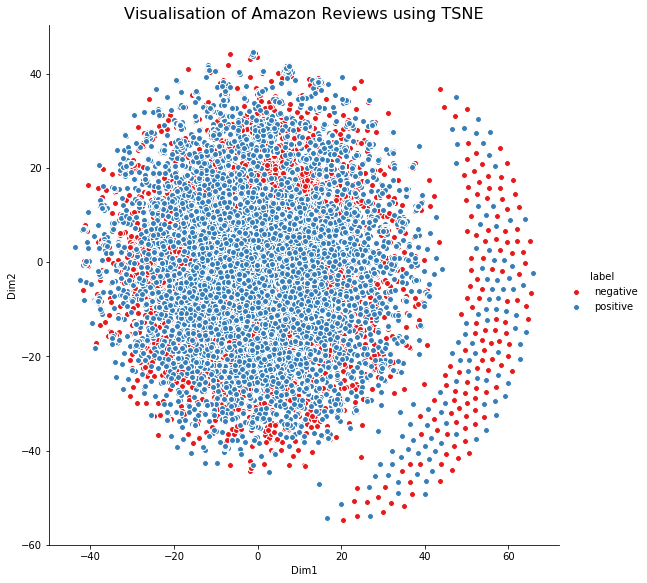

Time taken : 28.323005815347035 minutes


In [18]:
#tsne with 20k datapoints, perplexity=30 and step=1000 
print('\033[1m' + "Trial 1:"+ " TSNE Vsisualisation using BOW(unigram) with perplexity = 30 and step = 1000")
if __name__ == "__main__":
    tsne_plot(model_type=bow_unigram_tsvd,perplexity=30,n_iter=1000)

Trial 2: TSNE Vsisualisation using BOW with perplexity = 30 and step = 2000


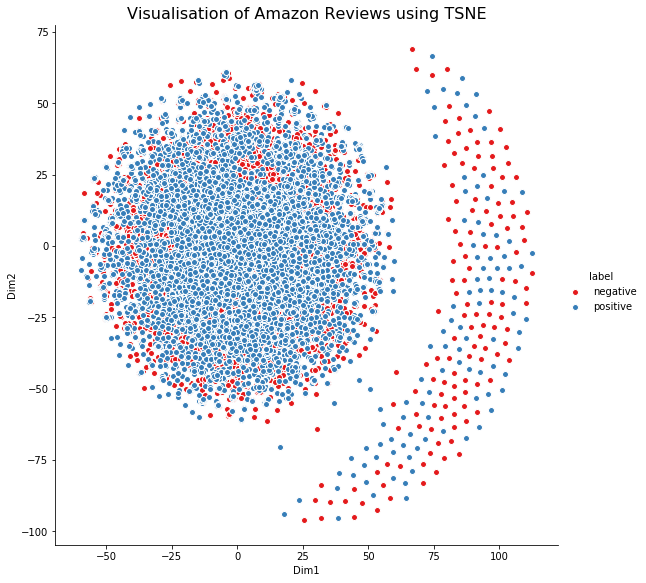

Time taken : 40.822129146258035 minutes


In [ ]:
#tsne with 20k datapoints , perplexity=30 and step=2000 
print('\033[1m' + "Trial 2:" + " TSNE Vsisualisation using BOW with perplexity = 30 and step = 2000")
if __name__ == "__main__":
    tsne_plot(model_type=bow_unigram_tsvd,perplexity=30,n_iter=2000)

Trial 3: TSNE Vsisualisation using BOW(unigram) with perplexity = 40 and step = 2000


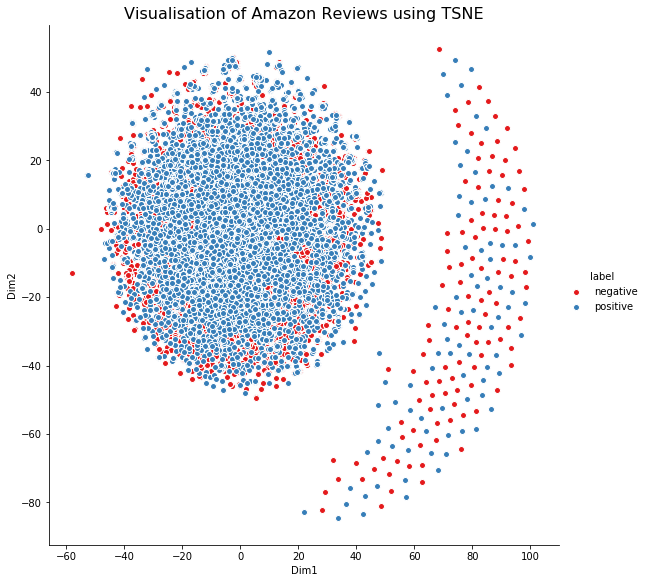

Time taken : 45.055972850322725 minutes


In [ ]:
#tsne with 20k datapoints, perplexity=40 and step=2000 
print('\033[1m' + "Trial 3:" + " TSNE Vsisualisation using BOW(unigram) with perplexity = 40 and step = 2000")
if __name__ == "__main__":
    tsne_plot(model_type=bow_unigram_tsvd,perplexity=40,n_iter=2000)

Trial 4: TSNE Vsisualisation using BOW(unigram) with perplexity = 50 and step = 3000


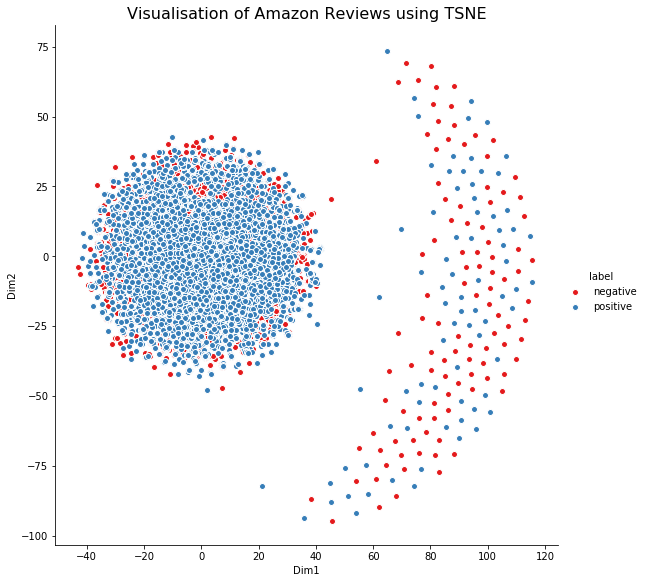

Time taken : 64.89492233594258 minutes


In [45]:
#tsne with 20k datapoints, perplexity=50 and step=3000 
print('\033[1m' + "Trial 4:" + " TSNE Vsisualisation using BOW(unigram) with perplexity = 50 and step = 3000")
if __name__ == "__main__":
    tsne_plot(model_type=bow_unigram_tsvd,perplexity=50,n_iter=3000)

### [6.2] Bag of Words(bigram) : <a name="bowbi"></a>

In [8]:
%%time
bow_bigram = CountVectorizer(ngram_range=(1,2))
final_bow_bigram = bow_bigram.fit_transform(final_text['CleanedText'].values)
print("the type of count vectorizer ",type(final_bow_bigram))
print("the shape of out text BOW vectorizer ",final_bow_bigram.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bow_bigram.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 416306)
the number of unique words including both unigrams and bigrams  416306
CPU times: user 3.39 s, sys: 32 ms, total: 3.42 s
Wall time: 3.42 s


In [9]:
dumpfile(final_bow_bigram,"bow_bigram")

In [10]:
final_bow_bigram = loadfile("bow_bigram")

#### [6.2.1] Applying Truncated SVD to reduce the dimensions and convert sparse <br> to dense matrix

In [11]:
%%time
from sklearn.decomposition import TruncatedSVD

tsvd1 = TruncatedSVD(n_components=1000,n_iter=5,random_state=3)
bow_bigram_tsvd = tsvd1.fit_transform(final_bow_bigram)

CPU times: user 14min 10s, sys: 20.7 s, total: 14min 31s
Wall time: 3min 37s


In [ ]:
dumpfile(tsvd1,"tsvd1")
dumpfile(bow_bigram_tsvd,"bow_bigram_tsvd")

In [ ]:
tsvd1 = loadfile("tsvd1")
bow_bigram_tsvd = loadfile("bow_bigram_tsvd")

In [13]:
bow_bigram_tsvd.shape

(20000, 1000)

Trial 1:TSNE Vsisualisation using BOW(bigram) with perplexity = 30 and step = 2000


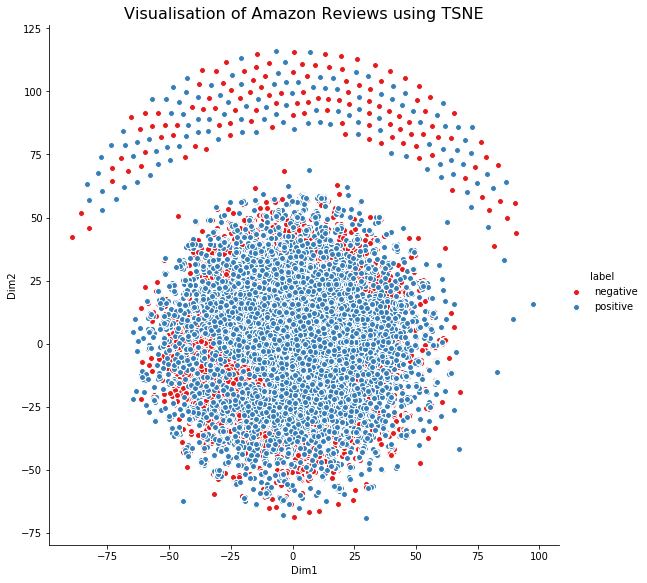

Time taken : 40.596174812316896 minutes


In [ ]:
#tsne with 20k datapoints, perplexity=30 and step=2000
print('\033[1m' + "Trial 1:" + "TSNE Vsisualisation using BOW(bigram) with perplexity = 30 and step = 2000")
if __name__ == "__main__":
    tsne_plot(model_type=bow_bigram_tsvd,perplexity=30,n_iter=2000)

Trial 2:TSNE Vsisualisation using BOW(bigram) with perplexity = 40 and step = 2000


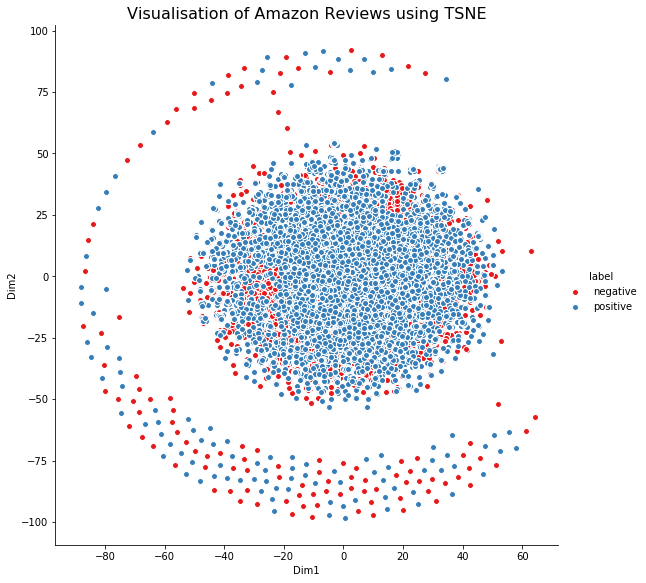

Time taken : 46.66869981686274 minutes


In [14]:
#tsne with 20k datapoints, perplexity=40 and step=2000
print('\033[1m' + "Trial 2:" + "TSNE Vsisualisation using BOW(bigram) with perplexity = 40 and step = 2000")
if __name__ == "__main__":
    tsne_plot(model_type=bow_bigram_tsvd,perplexity=40,n_iter=2000)

### [6.3] TF-IDF(unigram) : <a name="tfidfuni"></a>

In [33]:
%%time
tfidf_unigram = TfidfVectorizer()
final_tfidf_unigram = tfidf_unigram.fit_transform(final_text['CleanedText'].values)
print("the type of count vectorizer ",type(final_tfidf_unigram))
print("the shape of out text TFIDF vectorizer ",final_tfidf_unigram.get_shape())
print("the number of unique words ", final_tfidf_unigram.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 18575)
the number of unique words  18575
CPU times: user 992 ms, sys: 4 ms, total: 996 ms
Wall time: 995 ms


In [34]:
dumpfile(final_tfidf_unigram,"final_tfidf_unigram")

In [35]:
final_tfidf_unigram = loadfile("final_tfidf_unigram")

#### [6.3.1] Applying Truncated SVD to reduce the dimensions and convert sparse <br> to dense matrix

In [37]:
%%time
from sklearn.decomposition import TruncatedSVD

tsvd2 = TruncatedSVD(n_components=2000,n_iter=5,random_state=3)
tfidf_unigram_tsvd = tsvd2.fit_transform(final_tfidf_unigram)

CPU times: user 8min 16s, sys: 14 s, total: 8min 30s
Wall time: 1min 21s


In [38]:
dumpfile(tsvd2,"tsvd2")
dumpfile(tfidf_unigram_tsvd,"tfidf_unigram_tsvd")

In [46]:
tfidf_unigram_tsvd = loadfile("tfidf_unigram_tsvd")

In [47]:
tfidf_unigram_tsvd.shape

(20000, 2000)

Trial 1: TSNE Vsisualisation using TF-IDF(unigram) with perplexity = 30 and step = 1000


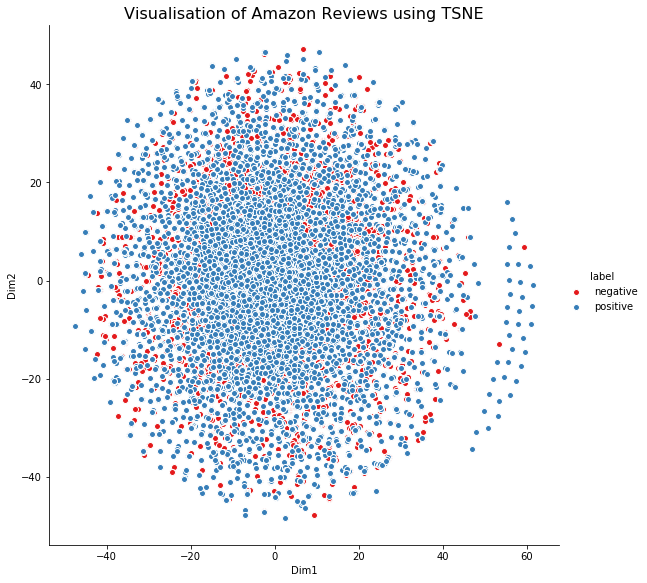

Time taken : 41.899857290585835 minutes


In [43]:
#tsne with 20k datapoints , perplexity=30 and step=1000
print('\033[1m'  + "Trial 1:" + " TSNE Vsisualisation using TF-IDF(unigram) with perplexity = 30 and step = 1000")
if __name__ == "__main__":
    tsne_plot(model_type=tfidf_unigram_tsvd,perplexity=30,n_iter=1000)

Trial 2: TSNE Vsisualisation using TF-IDF with perplexity = 30 and step = 2000


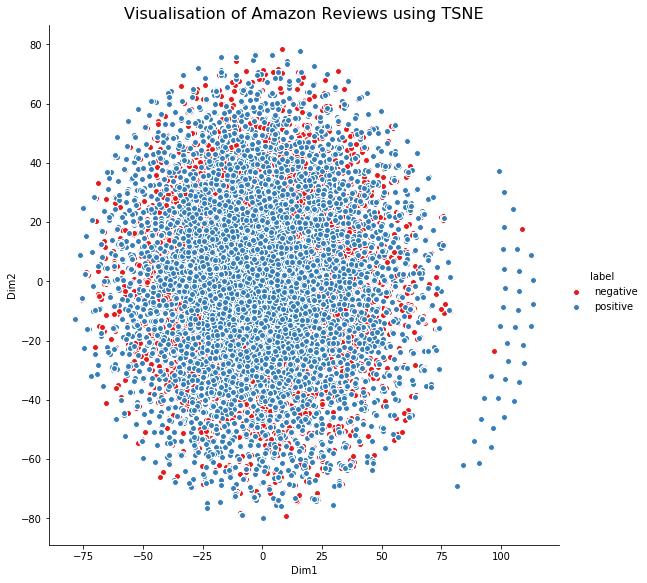

Time taken : 54.95569438139598 minutes


In [44]:
#tsne with 20k datapoints, perplexity=30 and step=2000
print('\033[1m'  + "Trial 2:" + " TSNE Vsisualisation using TF-IDF with perplexity = 30 and step = 2000")
if __name__ == "__main__":
    tsne_plot(model_type=tfidf_unigram_tsvd,perplexity=30,n_iter=2000)

Trial 3: TSNE Vsisualisation using TF-IDF with perplexity = 40 and step = 2000


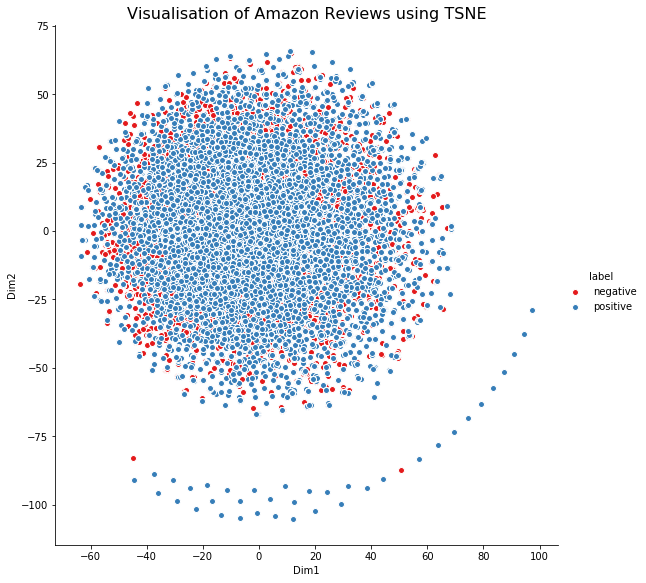

Time taken : 56.90793170531591 minutes


In [45]:
#tsne with 20k datapoints, perplexity=40 and step=2000
print('\033[1m'  + "Trial 3:" + " TSNE Vsisualisation using TF-IDF with perplexity = 40 and step = 2000")
if __name__ == "__main__":
    tsne_plot(model_type=tfidf_unigram_tsvd,perplexity=40,n_iter=2000)

Trial 4: TSNE Vsisualisation using TF-IDF with perplexity = 50 and step = 3000


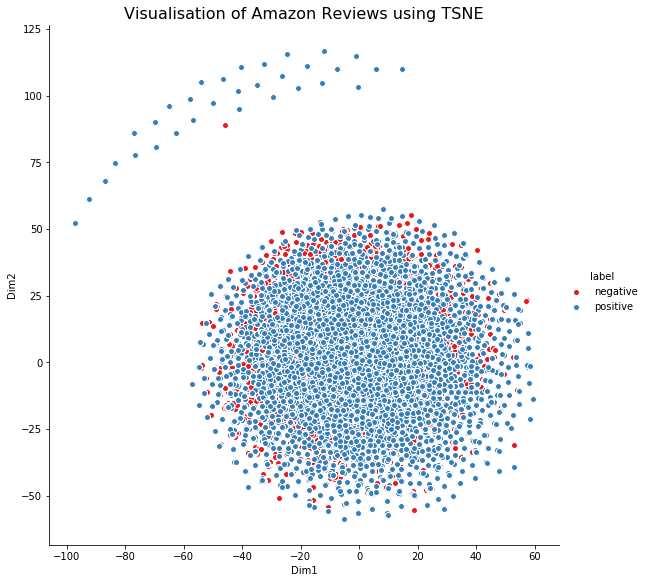

Time taken : 77.16757806142171 minutes


In [48]:
#tsne with 20k datapoints, perplexity=50 and step=3000
print('\033[1m'  + "Trial 4:" + " TSNE Vsisualisation using TF-IDF with perplexity = 50 and step = 3000")
if __name__ == "__main__":
    tsne_plot(model_type=tfidf_unigram_tsvd,perplexity=50,n_iter=3000)

### [6.4] TF-IDF(bigram) : <a name="tfidfbi"></a>

In [104]:
%%time
tfidf_bigram = TfidfVectorizer(ngram_range=(1,2))
final_tfidf_bigram = tfidf_bigram.fit_transform(final_text['CleanedText'].values)
print("the type of count vectorizer ",type(final_tfidf_bigram))
print("the shape of out text TFIDF vectorizer ",final_tfidf_bigram.get_shape())
print("the number of unique words ", final_tfidf_bigram.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 413909)
the number of unique words  413909
CPU times: user 3.75 s, sys: 36 ms, total: 3.78 s
Wall time: 3.79 s


In [11]:
dumpfile(final_tfidf_bigram,"final_tfidf_bigram")

In [102]:
final_tfidf_bigram = loadfile("final_tfidf_bigram")

In [105]:
features = tfidf_bigram.get_feature_names()
print("Some sample features(unique words in the corpus--->)",features[150000:150030])

Some sample features(unique words in the corpus--->) ['gas vent', 'gas well', 'gas world', 'gas would', 'gas yes', 'gas yesterday', 'gascogn', 'gascogn fig', 'gase', 'gase creat', 'gase time', 'gasket', 'gasket switch', 'gasolin', 'gasolin consid', 'gasolin disgust', 'gasolin gross', 'gasolin must', 'gasolin orang', 'gasolin petrol', 'gasolin problem', 'gasolin thought', 'gasp', 'gasp air', 'gasp breath', 'gasp first', 'gasp homemad', 'gasp rich', 'gasp saw', 'gasp took']


In [106]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['Feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tfidf_bigram[1,:].toarray()[0],features,25)
top_tfidf

Feature     tfidf
0      winner keeper  0.323165
1      fantast enjoy  0.323165
2         tri winner  0.323165
3      aroma fantast  0.310332
4         coffe must  0.279288
5             keeper  0.257350
6           must tri  0.250287
7       enjoy flavor  0.245863
8       flavor aroma  0.241983
9             winner  0.221286
10      great flavor  0.194109
11      flavor coffe  0.183116
12           fantast  0.174973
13             aroma  0.167677
14            flavor  0.157939
15              must  0.149306
16             enjoy  0.120175
17             coffe  0.101992
18             great  0.085673
19               tri  0.078605
20       flavor bodi  0.000000
21     flavor bright  0.000000
22      flavor bread  0.000000
23      flavor break  0.000000
24  flavor breakdown  0.000000

#### [6.4.1] Applying Truncated SVD to reduce the dimensions and convert sparse <br> to dense matrix

In [28]:
%%time
from sklearn.decomposition import TruncatedSVD

tsvd3 = TruncatedSVD(n_components=2000,n_iter=5,random_state=3)
tfidf_bigram_tsvd = tsvd3.fit_transform(final_tfidf_bigram)

CPU times: user 40min 45s, sys: 45.4 s, total: 41min 30s
Wall time: 11min 25s


In [ ]:
dumpfile(tsvd3,"tsvd3")
dumpfile(tfidf_bigram_tsvd,"tfidf_bigram_tsvd")

In [ ]:
tfidf_bigram_tsvd = loadfile("tfidf_bigram_tsvd")

In [29]:
tfidf_bigram_tsvd.shape

(20000, 2000)

Trial 1: TSNE Vsisualisation using TF-IDF(bigram) with perplexity = 30 and step = 2000


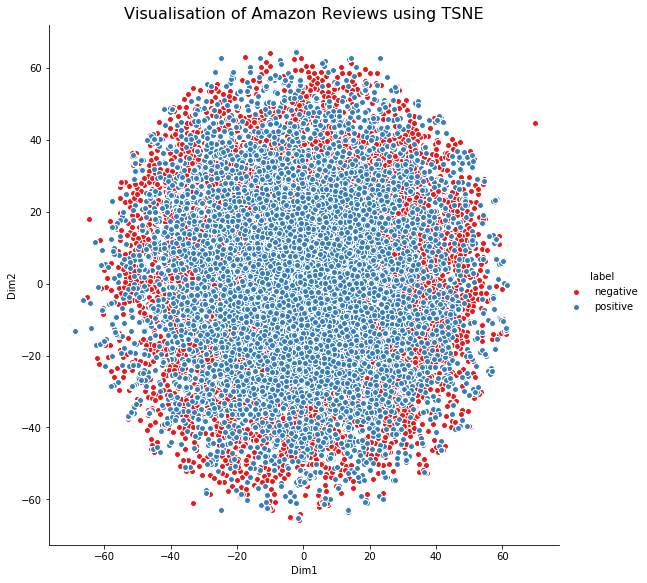

Time taken : 52.62612951199214 minutes


In [30]:
#tsne with 20k datapoints, perplexity=30 and step=2000 
print('\033[1m' + "Trial 1:" +  " TSNE Vsisualisation using TF-IDF(bigram) with perplexity = 30 and step = 2000")
if __name__ == "__main__":   
    tsne_plot(model_type=tfidf_bigram_tsvd,perplexity=30,n_iter=2000)

Trial 2: TSNE Vsisualisation using TF-IDF(bigram) with perplexity = 40 and step = 2000


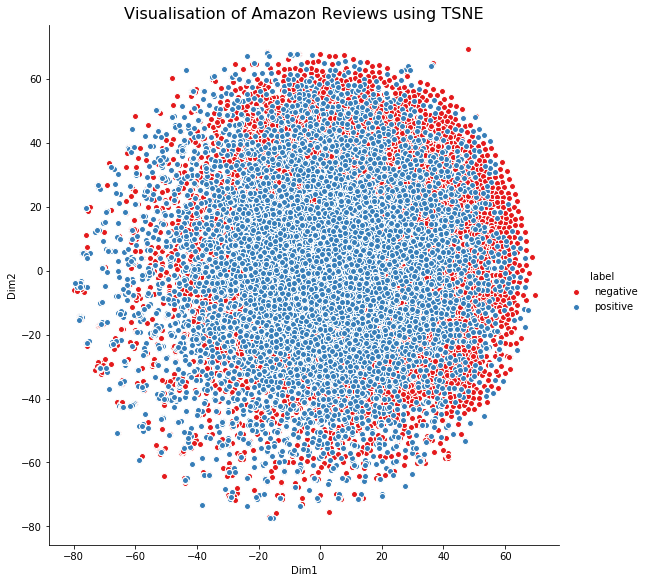

Time taken : 57.30884133974711 minutes


In [31]:
#tsne with 20k datapoints, perplexity=40 and step=2000 
print('\033[1m' + "Trial 2:" +  " TSNE Vsisualisation using TF-IDF(bigram) with perplexity = 40 and step = 2000")
if __name__ == "__main__":   
    tsne_plot(model_type=tfidf_bigram_tsvd,perplexity=40,n_iter=2000)

### [6.5] Building Word2Vec Model: <a name="w2v"></a>

In [20]:
# Training own Word2Vec model using our own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [20]:
print(final['CleanedText'].values[0])
print("****************************************************************************")
print(list_of_sent[0])

product archer farm best drink mix ever mix flavor packet water bottl contain natur sweetner stevia real fruit flavor food color color fruit veget color pure natur tast great eight packet box contain calori per packet thank archer farm
****************************************************************************
['product', 'archer', 'farm', 'best', 'drink', 'mix', 'ever', 'mix', 'flavor', 'packet', 'water', 'bottl', 'contain', 'natur', 'sweetner', 'stevia', 'real', 'fruit', 'flavor', 'food', 'color', 'color', 'fruit', 'veget', 'color', 'pure', 'natur', 'tast', 'great', 'eight', 'packet', 'box', 'contain', 'calori', 'per', 'packet', 'thank', 'archer', 'farm']


In [21]:
## Word2Vec Model considering only those words that occur atleast 5 times in the corpus
min_count = 5
w2v_model = Word2Vec(list_of_sent, min_count = min_count, size = 50, workers = 4)

In [23]:
w2v_words = list(w2v_model.wv.vocab)
print("Number of words occured atleast 5 times: ",len(w2v_words))
print("Sample Words: ",w2v_words[:50])
print("Vector Representation of tasti: ",w2v_model.wv['tasti'])

Number of words occured atleast 5 times:  21932
Sample Words:  ['product', 'archer', 'farm', 'best', 'drink', 'mix', 'ever', 'flavor', 'packet', 'water', 'bottl', 'contain', 'natur', 'sweetner', 'stevia', 'real', 'fruit', 'food', 'color', 'veget', 'pure', 'tast', 'great', 'eight', 'box', 'calori', 'per', 'thank', 'dog', 'love', 'saw', 'pet', 'store', 'tag', 'attach', 'regard', 'made', 'china', 'satisfi', 'safe', 'chicken', 'wont', 'buy', 'anymor', 'hard', 'find', 'usa', 'one', 'isnt', 'bad']
Vector Representation of tasti:  [-0.70755285  0.75774986  0.3984168   0.00853364 -1.5171229  -1.5281432
 -2.9212322   0.7913548  -0.9980168  -1.0965887  -0.34630695 -0.647944
  1.2014459  -0.3603521  -0.7953425  -1.8909314   1.3494714  -1.3049235
 -0.9310258   0.7560893  -2.0787907  -0.7147341  -1.3098463  -0.72061133
  2.3319848   0.38980323  1.6073657   1.61417     1.6891181  -2.2085228
 -1.5609965  -0.44740224 -3.560114   -2.1875746   1.4220233  -0.33471075
  0.80081904 -1.446908   -1.073569   

In [23]:
w2v_model.wv.most_similar('laugh')

[('joke', 0.7718126773834229),
 ('giggl', 0.7680538892745972),
 ('dude', 0.7506221532821655),
 ('hilari', 0.7381879091262817),
 ('smile', 0.7376969456672668),
 ('exclaim', 0.7275298833847046),
 ('oooh', 0.7136040329933167),
 ('tale', 0.7040639519691467),
 ('envi', 0.7035173177719116),
 ('yell', 0.6978278160095215)]

In [24]:
w2v_model.wv.most_similar('hate')

[('dislik', 0.7457690238952637),
 ('gross', 0.7006981372833252),
 ('yuck', 0.675076425075531),
 ('yucki', 0.6624249219894409),
 ('aw', 0.6515260338783264),
 ('nasti', 0.6390275359153748),
 ('weird', 0.6276780962944031),
 ('like', 0.6182881593704224),
 ('horribl', 0.6138617992401123),
 ('funni', 0.6108497977256775)]

In [25]:
w2v_model.wv.most_similar('eat')

[('scarf', 0.7091285586357117),
 ('ate', 0.6916272640228271),
 ('gobbl', 0.680194616317749),
 ('nibbl', 0.677663266658783),
 ('eaten', 0.6699792146682739),
 ('munch', 0.6558965444564819),
 ('sneak', 0.6535565257072449),
 ('feed', 0.6433646082878113),
 ('starv', 0.6413041949272156),
 ('devour', 0.6269568204879761)]

In [23]:
# Function for building the tsne model for Average word2vec
import time
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

def tsne_plot_word2vec(model_type,n_per_class,perplexity,n_iter):
    
    start = time.time()
    
    w2v_text_stdzd = StandardScaler().fit_transform(model_type)
    w2v_text_stdzd = pd.DataFrame(w2v_text_stdzd)
    #sampling of equal no of reviews from positive and negative classes
    w2v_text,w2v_score = reviews_eq_split(w2v_text_stdzd,score,n_per_class = n_per_class, random_state=0 )
    
    
    model = TSNE(n_components = 2, perplexity = perplexity, n_iter = n_iter, random_state = 0)
    tsne_data = model.fit_transform(w2v_text)
    
    #Visualisation
    tsne_data = np.vstack((tsne_data.T,w2v_score)).T
    tsne_df = pd.DataFrame(data = tsne_data, columns = ["Dim1","Dim2","label"])
    
    sns.FacetGrid(tsne_df, hue = "label", size = 8,palette="Set1", hue_order=["negative", "positive"]) \
             .map(plt.scatter, "Dim1", "Dim2", edgecolor="w") \
             .add_legend()
    plt.title("Visualisation of Amazon Reviews using TSNE").set_fontsize('16')
    plt.show()
    
    end = time.time()
    print("Time taken : {} minutes".format((end-start)/60))

### [6.6] Average Word2Vec : <a name="avgw2v"></a>

In [27]:
%%time
avgw2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent:
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgw2v_vectors.append(sent_vec)

CPU times: user 13min 36s, sys: 212 ms, total: 13min 37s
Wall time: 13min 37s


In [29]:
print("No of rows: ",len(avgw2v_vectors))
print("No of features: ",len(avgw2v_vectors[0]))

No of rows:  363599
No of features:  50


In [30]:
dumpfile(avgw2v_vectors,"avgw2v_vectors")

In [24]:
avgw2v_vectors = loadfile("avgw2v_vectors")

In [25]:
print("Average Word2Vec for a sample review: ",avgw2v_vectors[5])

Average Word2Vec for a sample review:  [ 0.1804632   0.46927066  0.48778807  0.81361585  0.45845246 -0.65252466
  0.12742814  1.07286664  0.16154231 -0.10292377  0.85694639 -0.71179361
 -0.74308931 -0.22152189  0.13254742 -1.15978997 -0.43779568  1.62098259
  0.1433036   0.55422866 -0.11114155  0.35580127 -0.63912219  0.86382019
  0.05309453 -1.2974659  -0.07057755  0.40277348 -0.05026361 -1.16636
  0.0157689  -0.29629692  0.73896502  0.05240768  0.9018119   0.88317991
  1.41605607  0.1563332  -0.45285661 -0.38159101 -0.75324475  1.00156159
  0.97529844  1.06607255  1.38718854  0.78120072 -0.45951304  0.22168467
  0.63788411 -0.51574704]


Trial 1: TSNE Vsisualisation using Average Word2Vec  with perplexity = 30 and step = 1000


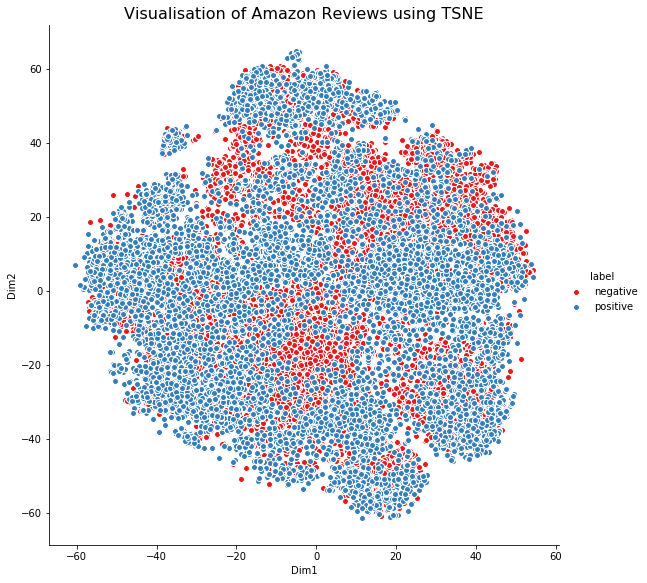

Time taken : 14.091036347548167 minutes


In [32]:
#tsne with 20k datapoints, perplexity=30 and step=1000
print('\033[1m'  + "Trial 1:" + " TSNE Vsisualisation using Average Word2Vec  with perplexity = 30 and step = 1000")
if __name__ == "__main__":
    tsne_plot_word2vec(model_type=avgw2v_vectors,n_per_class=10000,perplexity=30,n_iter=1000)

Trial 2: TSNE Vsisualisation using Average Word2Vec  with perplexity = 30 and step = 2000


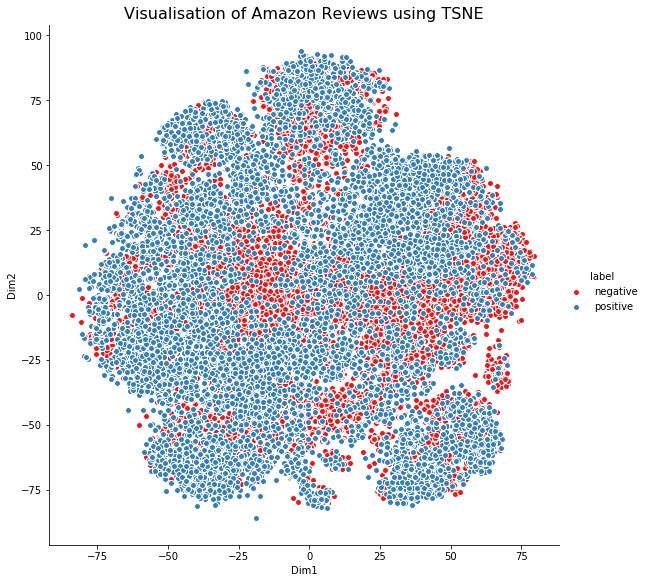

Time taken : 23.731491700808206 minutes


In [11]:
#tsne with 20k datapoints , perplexity=30 and step=2000
print('\033[1m'  + "Trial 2:" + " TSNE Vsisualisation using Average Word2Vec  with perplexity = 30 and step = 2000")
if __name__ == "__main__":
    tsne_plot_word2vec(model_type=avgw2v_vectors,n_per_class=10000,perplexity=30,n_iter=2000)

Trial 3: TSNE Vsisualisation using Average Word2Vec  with perplexity = 40 and step = 2000


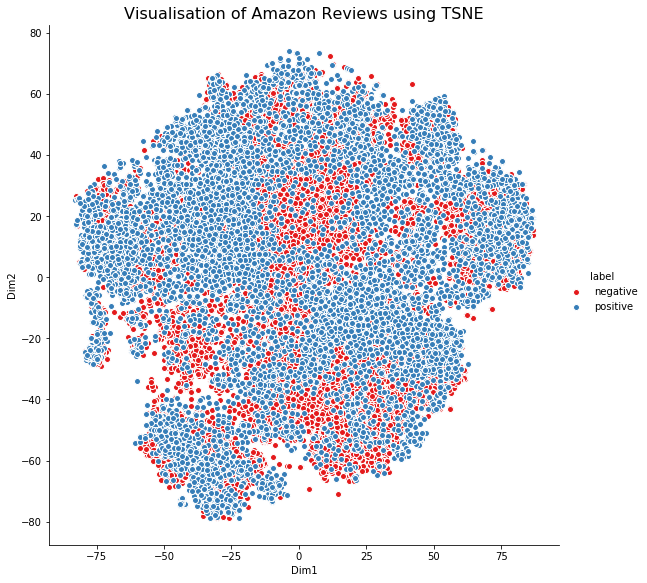

Time taken : 27.039929429690044 minutes


In [ ]:
#tsne with 20k datapoints, perplexity=40 and step=2000
print('\033[1m'  + "Trial 3:" + " TSNE Vsisualisation using Average Word2Vec  with perplexity = 40 and step = 2000")
if __name__ == "__main__":
    tsne_plot_word2vec(model_type=avgw2v_vectors,n_per_class=10000,perplexity=40,n_iter=2000)

Trial 4: TSNE Vsisualisation using Average Word2Vec  with perplexity = 50 and step = 3000


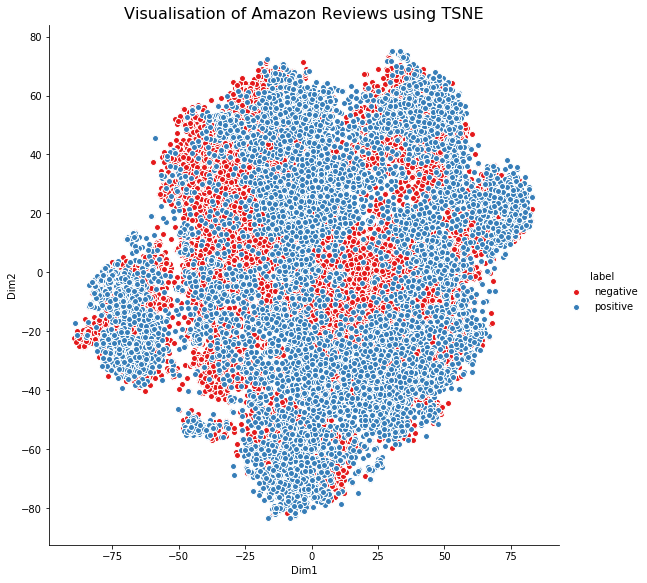

Time taken : 44.99700769980748 minutes


In [26]:
#tsne with 20k datapoints, perplexity=50 and step=3000
print('\033[1m'  + "Trial 4:" + " TSNE Vsisualisation using Average Word2Vec  with perplexity = 50 and step = 3000")
if __name__ == "__main__":
    tsne_plot_word2vec(model_type=avgw2v_vectors,n_per_class=10000,perplexity=50,n_iter=3000)

### [6.7] TF-IDF weighted Word2Vec : <a name="tfidfw2v"></a>

In [31]:
tfidf_w2v = TfidfVectorizer(ngram_range=(1,2))
tfidf_w2v_vector = tfidf_w2v.fit_transform(final_text['CleanedText'].values)
print("the type of count vectorizer ",type(tfidf_w2v_vector))
print("the shape of out text TFIDF vectorizer ",tfidf_w2v_vector.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_w2v_vector.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 413891)
the number of unique words including both unigrams and bigrams  413891


In [36]:
i=0
sentence=[]
for sent in final_text['CleanedText'].values:
    sentence.append(sent.split())
    
print(len(sentence))

20000


In [41]:
print("Before: ",final_text['CleanedText'].values[0])
print("*************************************************************")
print("After: ",sentence[0])

Before:  tri blend lavazza someth dark fresh like pete morn blend make delici rich yet smooth coffe
*************************************************************
After:  ['tri', 'blend', 'lavazza', 'someth', 'dark', 'fresh', 'like', 'pete', 'morn', 'blend', 'make', 'delici', 'rich', 'yet', 'smooth', 'coffe']


In [42]:
%%time
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_w2v.get_feature_names() 
tfidf_sent_vectors = [];
row=0;
for sent in sentence:
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = tfidf_w2v_vector[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

CPU times: user 2h 55min 34s, sys: 752 ms, total: 2h 55min 35s
Wall time: 2h 55min 35s


In [44]:
dumpfile(tfidf_sent_vectors,"tfidf_sent_vectors")

In [27]:
tfidf_sent_vectors = loadfile("tfidf_sent_vectors")

In [28]:
print("TF-IDF weighted Word2Vec for a sample review: ",tfidf_sent_vectors[5])

TF-IDF weighted Word2Vec for a sample review:  [-1.13244024 -1.5944258   0.57760882 -0.06147624  3.54582173  0.88965442
  0.09427476  1.02660133 -0.32685487 -2.04121467 -0.96966311 -2.93753077
 -0.36500973 -0.43538882 -1.10112348  0.0683815   2.00930813 -0.38554674
  0.04768718  0.92737204 -0.74863279 -1.00440626 -2.6405003   0.39700624
  1.04813927 -0.76246688 -0.92853129  0.20019288 -2.05303851 -1.05829101
  1.01946734 -0.34166203 -0.30994027  1.87219609 -1.63305307 -2.4587577
 -0.48399351  0.15829074  0.0790891  -0.6525564  -1.39704862  0.39320733
  0.93066265  1.31715535 -2.98070872 -2.45727821 -0.5201301   1.67396904
  2.0703425  -1.18841692]


Trial 1: TSNE Vsisualisation using TF-IDF weighted Word2Vec  with perplexity = 30 and step = 1000


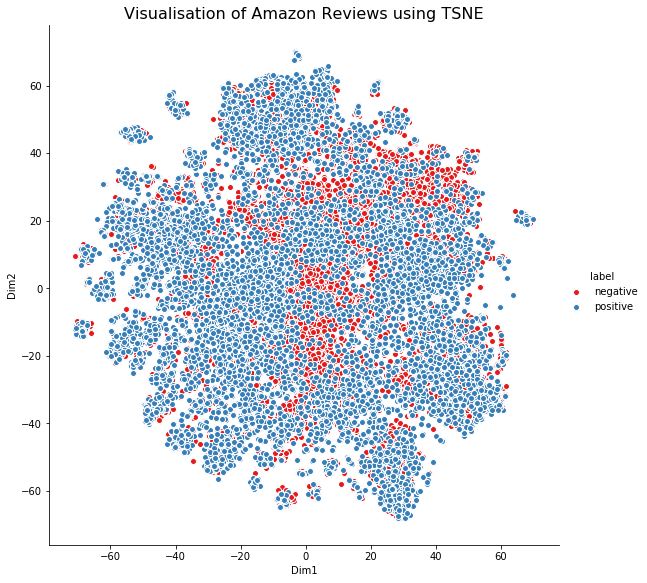

Time taken : 12.310085189342498 minutes


In [60]:
#tsne with 20k datapoints, perplexity=30 and step=1000
print('\033[1m'  + "Trial 1:" + " TSNE Vsisualisation using TF-IDF weighted Word2Vec  with perplexity = 30 and step = 1000")
if __name__ == "__main__":
    tsne_plot(model_type=tfidf_sent_vectors,perplexity=30,n_iter=1000)

Trial 2: TSNE Vsisualisation using TF-IDF weighted Word2Vec  with perplexity = 30 and step = 2000


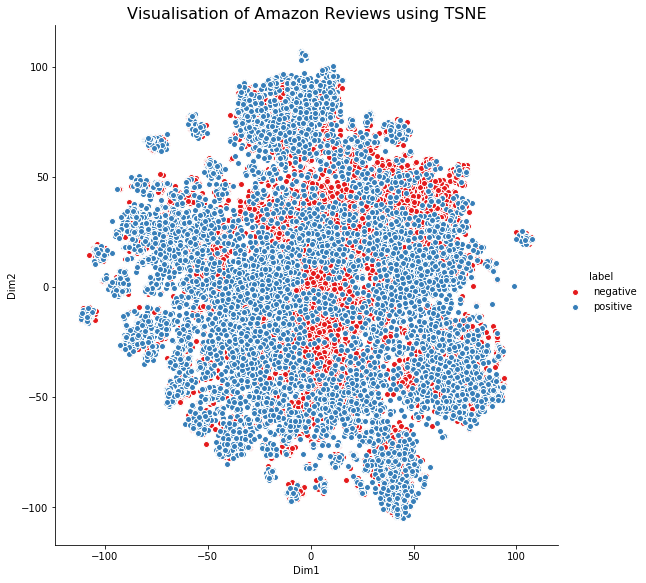

Time taken : 23.815266184012096 minutes


In [61]:
#tsne with 20k datapoints , perplexity=30 and step=2000
print('\033[1m'  + "Trial 2:" + " TSNE Vsisualisation using TF-IDF weighted Word2Vec  with perplexity = 30 and step = 2000")
if __name__ == "__main__":
    tsne_plot(model_type=tfidf_sent_vectors,perplexity=30,n_iter=2000)

Trial 3: TSNE Vsisualisation using TF-IDF weighted Word2Vec  with perplexity = 40 and step = 2000


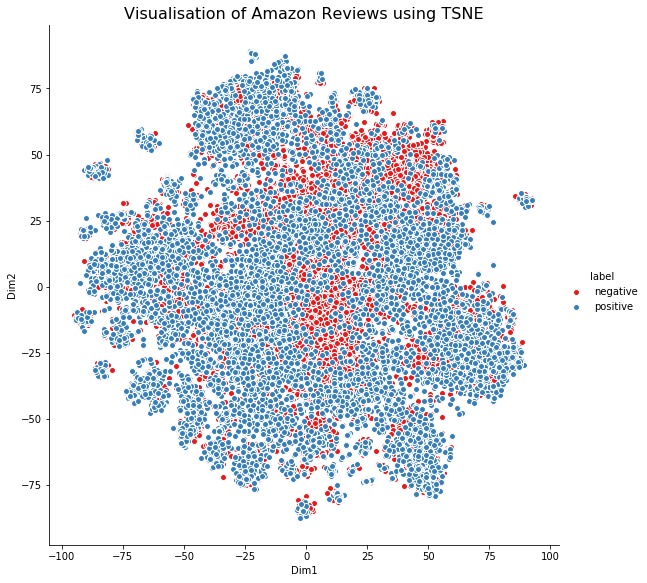

Time taken : 26.405626034736635 minutes


In [62]:
#tsne with 20k datapoints, perplexity=40 and step=2000
print('\033[1m'  + "Trial 3:" + " TSNE Vsisualisation using TF-IDF weighted Word2Vec  with perplexity = 40 and step = 2000")
if __name__ == "__main__":
    tsne_plot(model_type=tfidf_sent_vectors,perplexity=40,n_iter=2000)

Trial 4: TSNE Vsisualisation using TF-IDF weighted Word2Vec  with perplexity = 50 and step = 3000


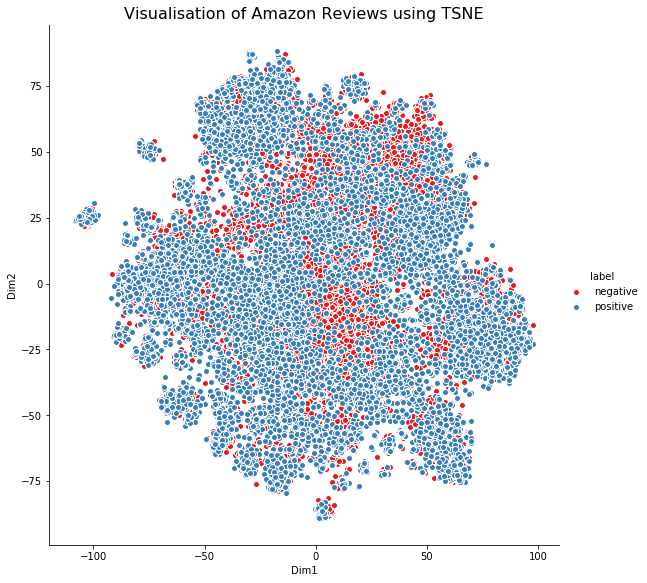

Time taken : 43.8861537138621 minutes


In [32]:
#tsne with 20k datapoints, perplexity=50 and step=3000
print('\033[1m'  + "Trial 4:" + " TSNE Vsisualisation using TF-IDF weighted Word2Vec  with perplexity = 50 and step = 3000")
if __name__ == "__main__":
    tsne_plot(model_type=tfidf_sent_vectors,perplexity=50,n_iter=3000)

## [7] Conclusion : <a name="conclusion"></a>
<b>1 - </b>Reviews in text were converted to vectors using BOW, TF-IDF, Average Word2Vec anf TF-IDF Weighted Word2Vec.  
<b>2 - </b>Using all the featurization techniques, TSNE plots were done to visualize the polarity of reviews    with different combinations of perplexity and iterations.  
<b>3 - </b>All the t-SNE plots shows that the positive and negative reviews are <b>almost overlapping on the top of each other</b>.  
<b>4 - </b>We may conclude that <b>positive and negative reviews are not linearly separable</b>.  
<b>5 - </b>Hence, some <b>machine learning classification models can be used</b> to determine the polarity of reviews.